In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage.filters import threshold_otsu
import cv2
from sklearn.cluster import KMeans
from sklearn import mixture
import scipy.stats as stats

In [2]:
from deepcardio_utils import *

## Sparks location and image list

In [3]:
mat = loadmat(os.path.join(DATASETS_PATH, MAT_PATH))['xytspark']
sparksDF = pd.DataFrame(mat, columns=['x','y','tIni','tFin'])
sparksDF.head()

,x,y,tIni,tFin
0,71,36,2,37
1,76,37,37,77
2,162,23,81,116
3,207,26,117,152
4,187,10,333,383


In [4]:
imageList = sorted(os.listdir(IMAGE_FOLDER))
imageList[:5]

['170215_RyR-GFP30_RO_01_Serie2_z10000_ch01.tif',
 '170215_RyR-GFP30_RO_01_Serie2_z10001_ch01.tif',
 '170215_RyR-GFP30_RO_01_Serie2_z10002_ch01.tif',
 '170215_RyR-GFP30_RO_01_Serie2_z10003_ch01.tif',
 '170215_RyR-GFP30_RO_01_Serie2_z10004_ch01.tif']

## Plot images and locate sparks

In [6]:
idx = 130
im = get_image_array(idx)
im.shape

(40, 256)

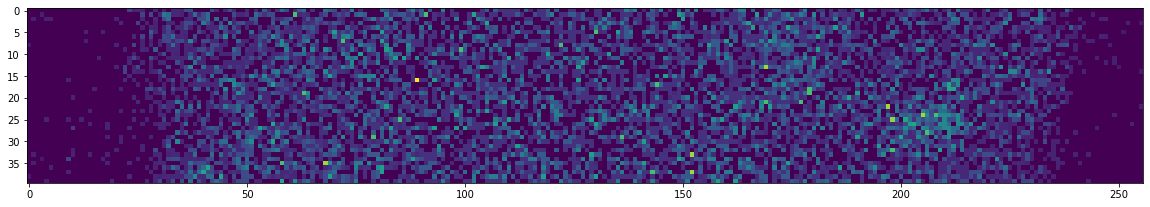

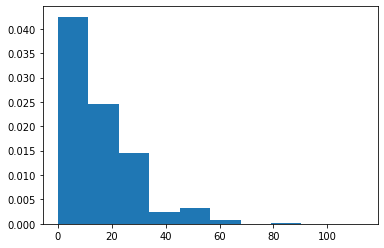

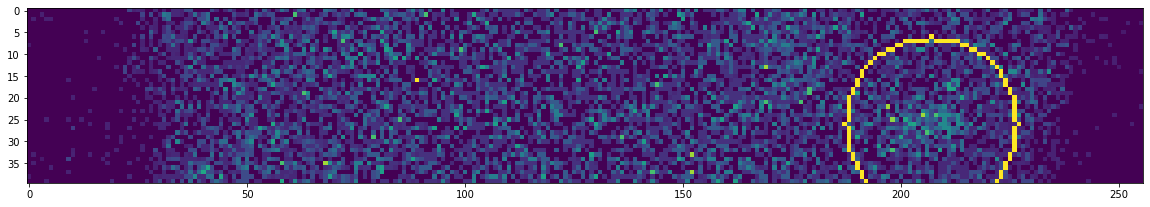

In [7]:
plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

plt.hist(im.flatten(), density=True)
plt.show()

# find spark
im_ = im.copy()
sparkLocation = get_spark_location(sparksDF, idx)
plt.figure(figsize=(20, 10))
color = int(im_.max())
plt.imshow(cv2.circle(im_, (sparkLocation['x'], sparkLocation['y']), 20, color, thickness=1, lineType=8, shift=0))
plt.show()

## Mask on the spark

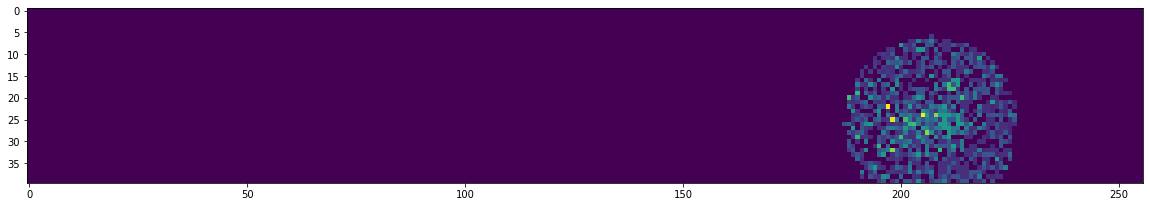

In [8]:
idx = 130
im = get_image_array(idx)
sparkLocation = get_spark_location(sparksDF, idx)
sparkLocation = sparkLocation.loc[sparkLocation.index[0]]
mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)
im[mask == False]=0

plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

## Spark highlight

### Binary threshold: arbitrary vs otsu

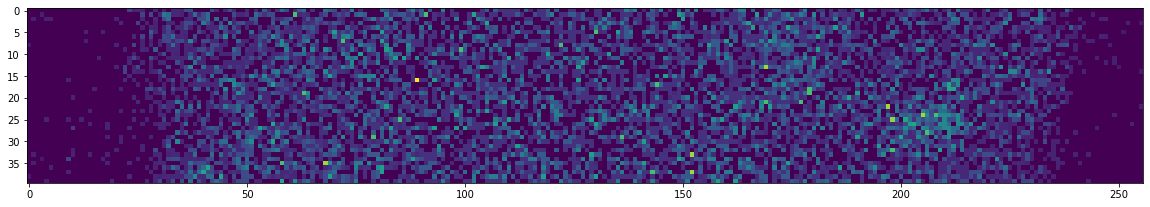

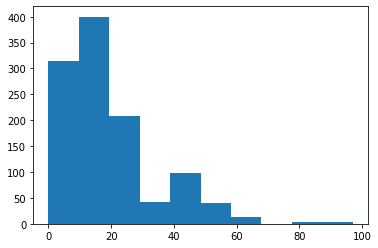

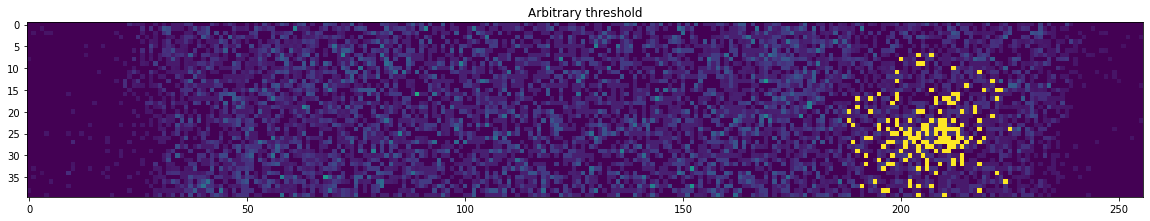

otsu threshold: 16


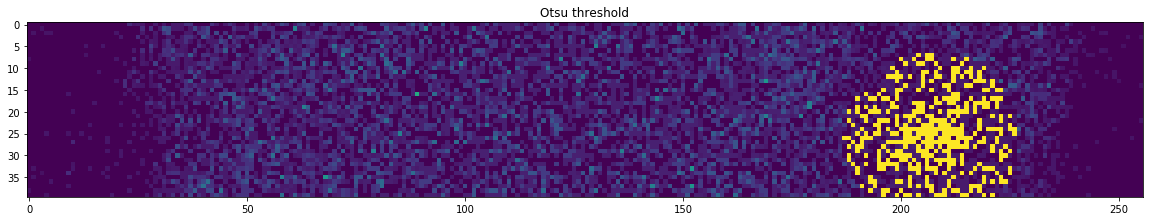

array([ 0, 11, 13, 16, 23, 26, 32, 34, 40, 46, 48, 53, 64, 67, 80, 94, 97],
      dtype=uint8)

In [9]:
idx = 130
im = get_image_array(idx)
im.shape
sparkLocation = get_spark_location(sparksDF, idx)
sparkLocation = sparkLocation.loc[sparkLocation.index[0]]

plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

# arbitrary
plt.hist(im[mask].flatten())
plt.show()

im_ = im.copy()
im_[mask] = np.where(im_[mask]>35, 3000, im_[mask])
plt.figure(figsize=(20, 10))
plt.imshow(im_)
plt.title('Arbitrary threshold')
plt.show()

# otsu
otsu = threshold_otsu(im[mask].flatten())
print(f"otsu threshold: {otsu}")

im_ = im.copy()
im_[mask] = np.where(im_[mask]>otsu, 3000, im_[mask])
plt.figure(figsize=(20, 10))
plt.imshow(im_)
plt.title('Otsu threshold')
plt.show()

np.unique(im[mask].flatten())

### KMeans

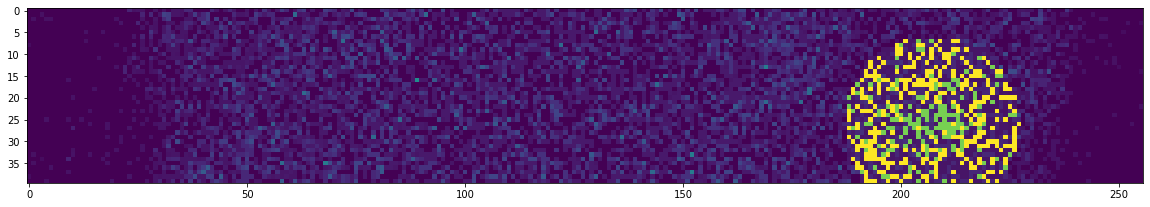

In [10]:
idx = 130
im = get_image_array(idx)
sparkLocation = get_spark_location(sparksDF, idx)
sparkLocation = sparkLocation.loc[sparkLocation.index[0]]
mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

k = KMeans(n_clusters=3).fit(im[mask].reshape(-1,1))
im[mask] = np.where(k.labels_==k.labels_[im[mask].argmax()], 3000, im[mask])
im[mask] = np.where(k.labels_==k.labels_[im[mask].argmin()], 1000, im[mask])

plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

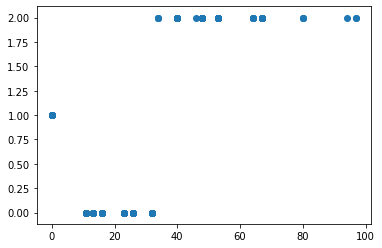

In [11]:
idx = 130
im = get_image_array(idx)
plt.scatter(im[mask].flatten(), k.labels_)
plt.show()

### Gaussian Mixture Models (GMM)

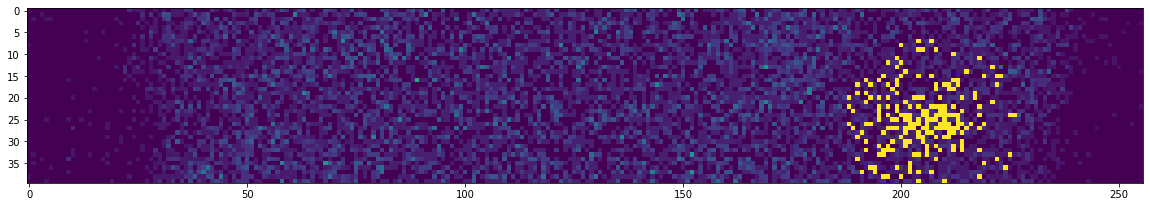

In [12]:
idx = 130
im = get_image_array(idx)
sparkLocation = get_spark_location(sparksDF, idx)
sparkLocation = sparkLocation.loc[sparkLocation.index[0]]
mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

gmm = mixture.GaussianMixture(n_components=3).fit(im[mask].reshape(-1,1))
lab = gmm.predict(im[mask].reshape(-1,1))
im[mask] = np.where(lab==lab[im[mask].argmax()], 3000, im[mask])

plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

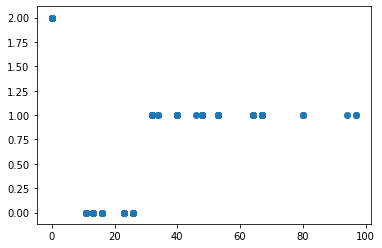

In [13]:
idx = 130
im = get_image_array(idx)
plt.scatter(im[mask].flatten(), lab)
plt.show()

### GMM with optimal BIC number

[9466.05435759548, 9301.741713154739, 3308.979925033026, 95.2959378920035, 1728.3241758126758, 100.25528325099269, -1812.4191074369778, -664.521694498963, -201.5619579249328, -254.88218953524787]
...and the winner is GMM model G = 4


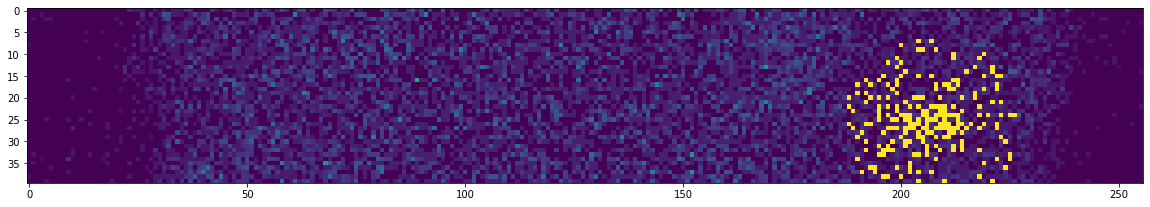

In [14]:
idx = 130
im = get_image_array(idx)
sparkLocation = get_spark_location(sparksDF, idx)
sparkLocation = sparkLocation.loc[sparkLocation.index[0]]
mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

#calcula el BIC per trobar el número de gaussianes òptim
NMAX = 10
bic = []
aic = []

for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG).fit(im[mask].reshape(-1,1))
    bic.append(gmm.bic(im[mask].reshape(-1,1))) #cada cop va afegint el bic amb kG+1, així ho tens tot en un vector i pots calcualr el mínim

print(bic)

idx_winner = np.argmin(np.abs(bic))
print('...and the winner is GMM model G = {}'.format(idx_winner+1))

gmm = mixture.GaussianMixture(n_components=(idx_winner+1)).fit(im[mask].reshape(-1,1))
lab = gmm.predict(im[mask].reshape(-1,1))
im[mask] = np.where(lab==lab[im[mask].argmax()], 3000, im[mask])

plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

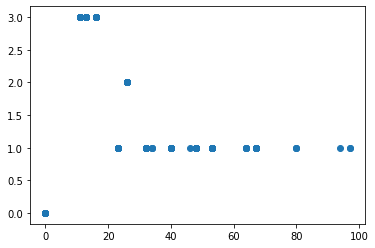

In [15]:
idx = 130
im = get_image_array(idx)
plt.scatter(im[mask].flatten(), lab)
plt.show()

### Using distance info

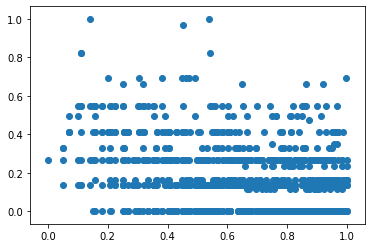

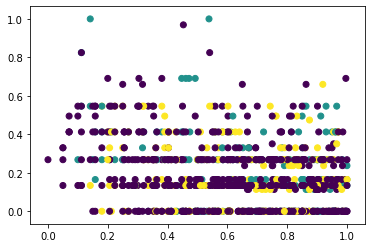

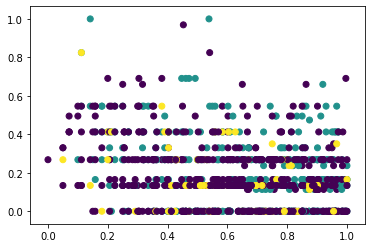

In [16]:
idx = 130
im = get_image_array(idx)
sparkLocation = get_spark_location(sparksDF, idx)
sparkLocation = sparkLocation.loc[sparkLocation.index[0]]
mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

y, x = np.ogrid[:im.shape[0], :im.shape[1]]
dist_from_center = np.sqrt((x - sparkLocation['x'])**2 + (y-sparkLocation['y'])**2)
aux = np.array([dist_from_center[mask].flatten(), im[mask].flatten()])
aux[0] /= aux[0].max()
aux[1] /= aux[1].max()

plt.scatter(aux[0], aux[1])
plt.show()

km = KMeans(n_clusters=3).fit(aux.reshape(-1,2))
plt.scatter(aux[0], aux[1], c=km.labels_)
plt.show()

gmm = mixture.GaussianMixture(n_components=3).fit(aux.reshape(-1, 2))
lab = gmm.predict(aux.reshape(-1, 2))
plt.scatter(aux[0], aux[1], c=lab)
plt.show()

### Combine plot image and spark segmentation

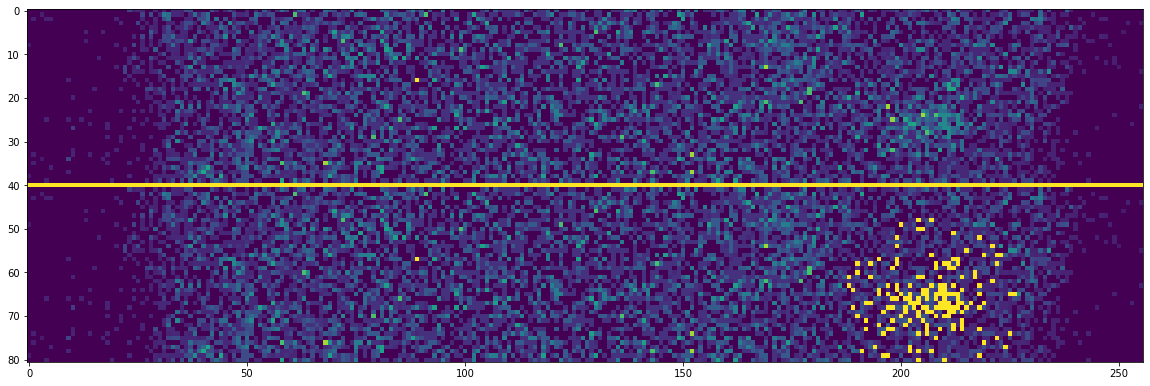

In [17]:
idx = 130
im = get_image_array(idx)
im_ = im.copy()
k = KMeans(n_clusters=3).fit(im_[mask].reshape(-1,1))
im_[mask] = np.where(k.labels_==k.labels_[im_[mask].argmax()], im.max(), im_[mask])

conc_im = np.concatenate((im, np.full((1,im.shape[1]), im_.max()), im_))
plt.figure(figsize=(20,10))
plt.imshow(conc_im)
plt.show()

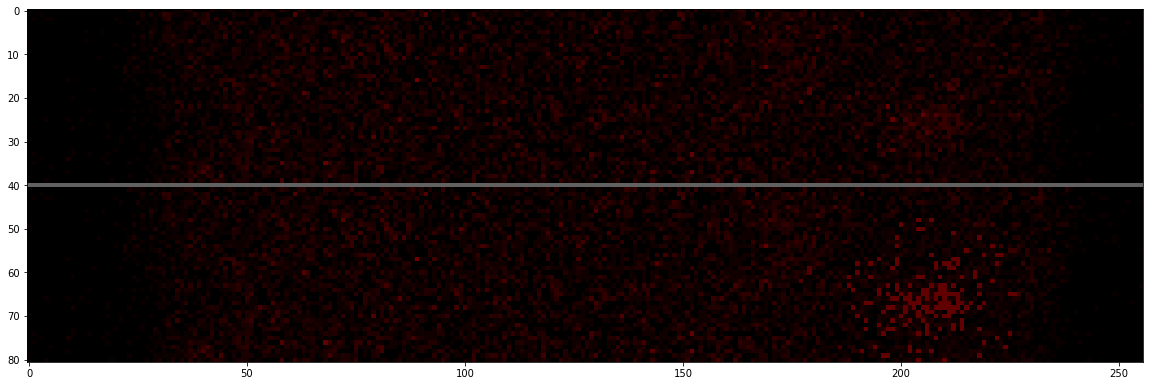

In [18]:
idx = 130
im = cv2.imread(get_image_path(idx))
im_ = im.copy()

sparkLocation = get_spark_location(sparksDF, idx)
sparkLocation = sparkLocation.loc[sparkLocation.index[0]]
mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

k = KMeans(n_clusters=3).fit(im_[mask].reshape(-1,3))
maxRValue = im_[mask,2].max()
maxValue = np.array([0, 0, maxRValue]).reshape(-1,3)
maxValueIdx = im_[mask, 2].argmax()
isSparkCond = np.full(im_[mask].shape, False)
isSparkCond[k.labels_ == k.labels_[maxValueIdx], 2] = True
im_[mask] = np.where(isSparkCond, maxRValue, im_[mask])

conc_im = np.concatenate((im, np.full((1,im.shape[1], 3), maxRValue), im_))
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(conc_im, cv2.COLOR_BGR2RGB))
plt.show()

### savefig spark frames KMeans

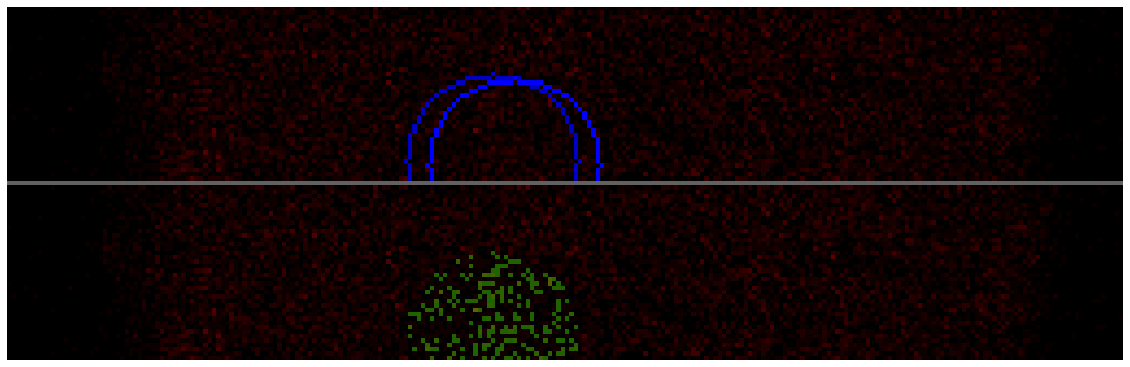

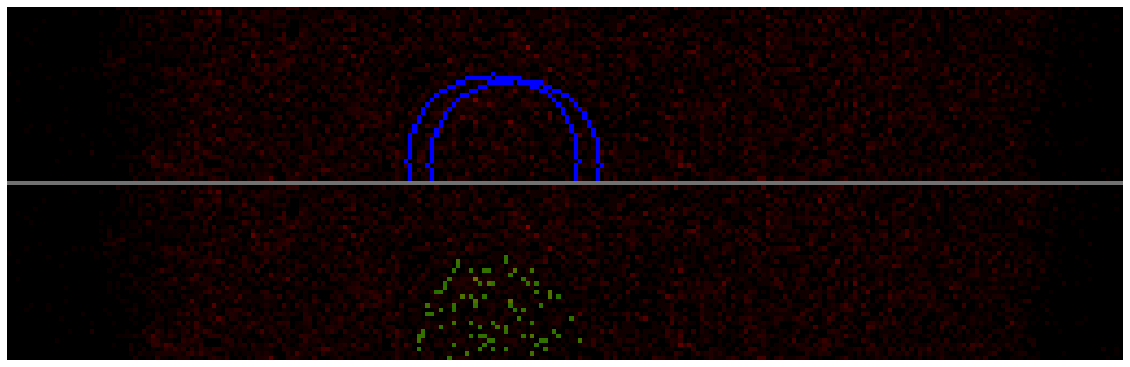

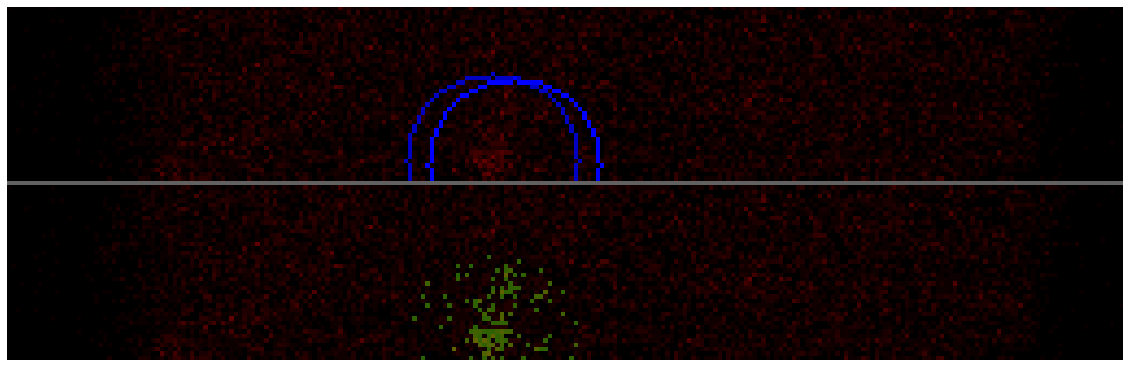

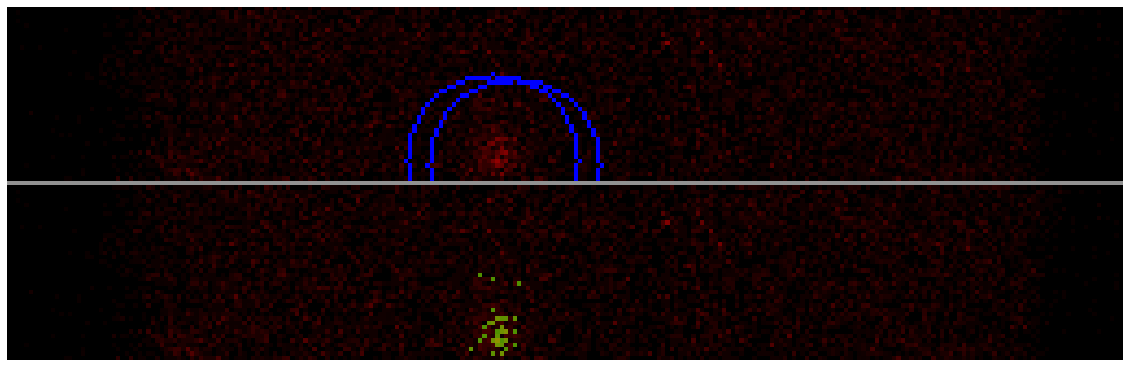

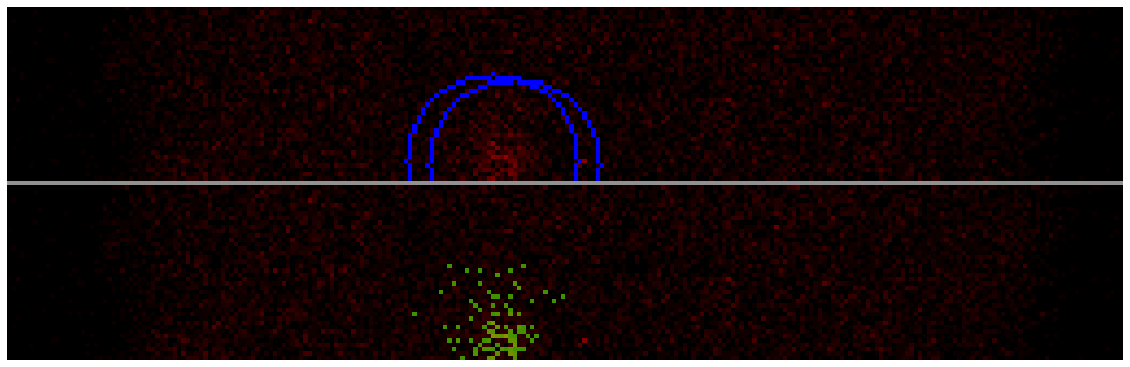

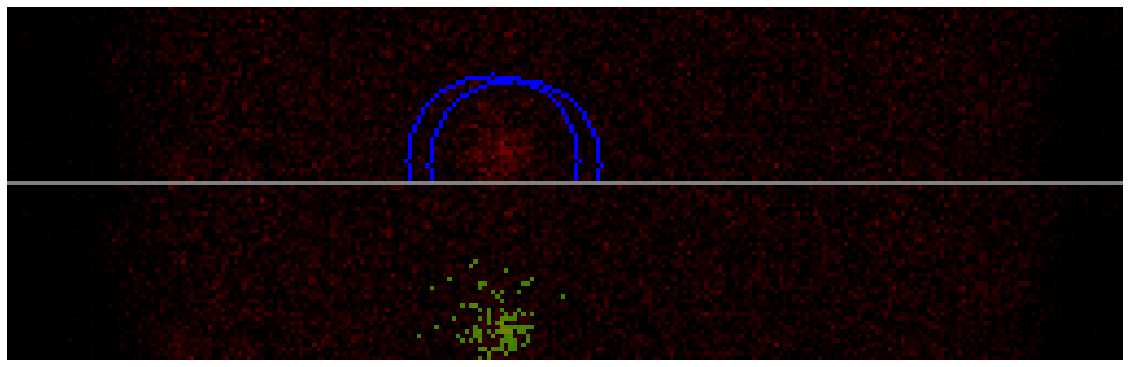

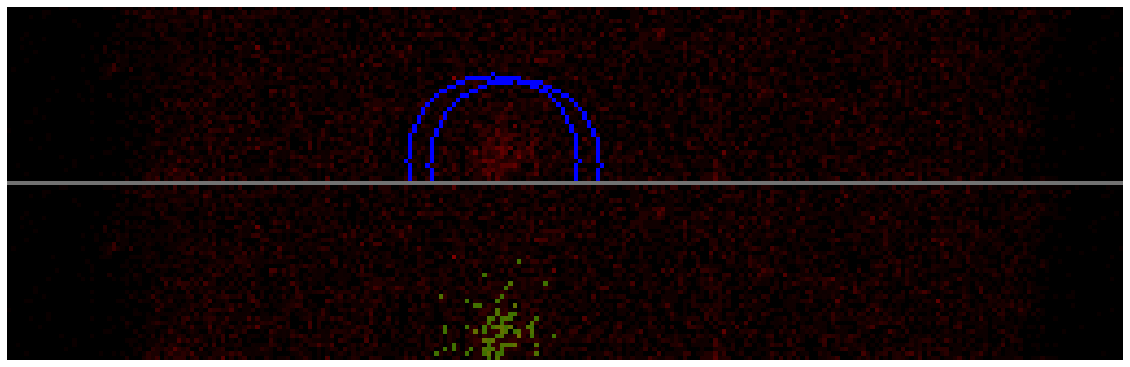

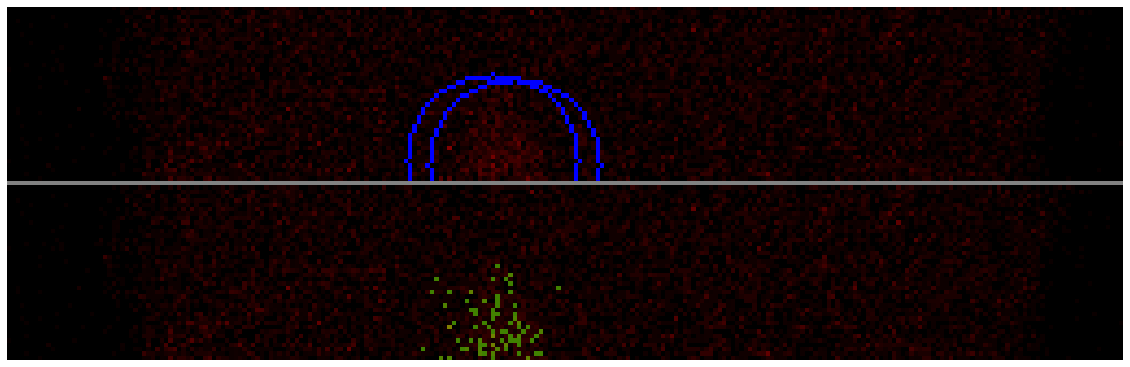

In [19]:
idx = 2008
for idx in range(2003, 2010+1):
    im = cv2.imread(get_image_path(idx))
    im_ = im.copy()

    sparkLocations = get_spark_location(sparksDF, idx)
    for i, sparkLocation in sparkLocations.iterrows():
        color = int(im.max()*2)
        cv2.circle(im, (sparkLocation['x'], sparkLocation['y']), 20, color, thickness=1, lineType=8, shift=0)

        mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

        k = KMeans(n_clusters=3).fit(im_[mask].reshape(-1,3))
        maxRValue = im_[mask,2].max()
        maxValue = np.array([0, 0, maxRValue]).reshape(-1,3)
        maxValueIdx = im_[mask, 2].argmax()
        isSparkCond = np.full(im_[mask].shape, False)
        isSparkCond[k.labels_ == k.labels_[maxValueIdx], 1] = True
        im_[mask] = np.where(isSparkCond, maxRValue, im_[mask])

    conc_im = np.concatenate((im, np.full((1,im.shape[1], 3), maxRValue), im_))
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(conc_im, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    # plt.title(f"{idx}")
    # plt.savefig(f"_out/spark{idx}", bbox_inches = 'tight', pad_inches = 0)
    plt.show()

### Use BIC for the number of mixtures

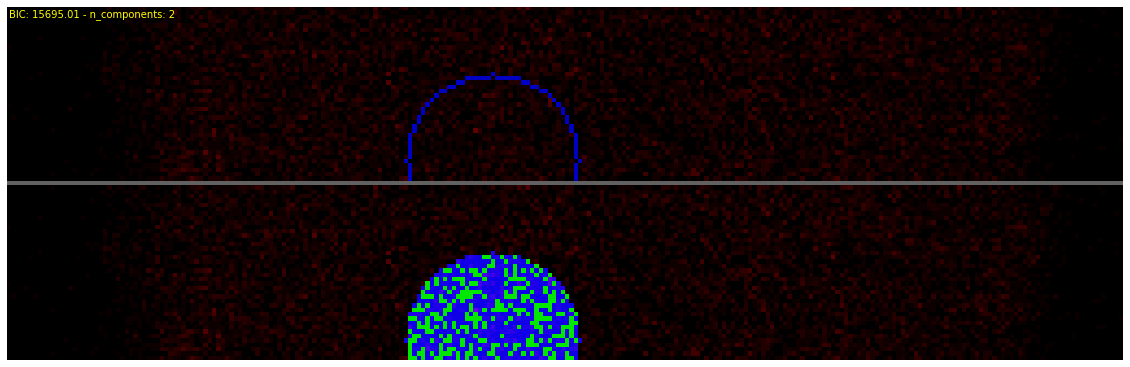

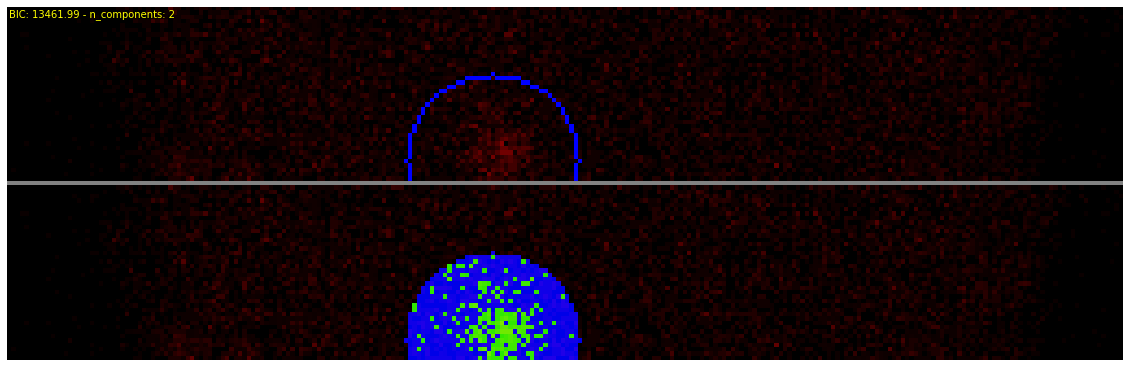

In [65]:
for idx in [2003, 2008]:
    im = cv2.imread(get_image_path(idx))
    im_ = im.copy()

    sparkLocations = get_spark_location(sparksDF, idx)
    gmmCounts = []
    # only first one
    i, sparkLocation = next(sparkLocations.iterrows())
    color = int(im.max()*2)

    mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

    #calcula el BIC per trobar el número de gaussianes òptim
    NMAX = 10
    bic = []

    for kG in np.arange(1,NMAX+1):
        gmm = mixture.GaussianMixture(n_components=kG).fit(im[mask].reshape(-1,1))
        bic.append(gmm.bic(im[mask].reshape(-1,1))) #cada cop va afegint el bic amb kG+1, així ho tens tot en un vector i pots calcualr el mínim

    idx_winner = np.argmin(np.abs(bic))
    gmmCounts.append(idx_winner+1)
    gmm = mixture.GaussianMixture(n_components=(idx_winner+1)).fit(im[mask].reshape(-1,3))
    lab = gmm.predict(im[mask].reshape(-1,3))

    maxRValue = im_[mask,2].max()
    maxValue = np.array([0, 0, maxRValue]).reshape(-1,3)
    maxValueIdx = im_[mask, 2].argmax()
    isSparkCond = np.full(im_[mask].shape, False)
    isSparkCond[lab == lab[maxValueIdx], 1] = True
    # im_[mask] = np.where(isSparkCond, maxRValue, im_[mask])
    im_[mask, lab]  = 1000

    cv2.circle(im, (sparkLocation['x'], sparkLocation['y']), 20, color, thickness=1, lineType=8, shift=0)
    conc_im = np.concatenate((im, np.full((1,im.shape[1], 3), maxRValue), im_))
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(conc_im, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    # plt.title(f"{idx}")
    plt.text(0, 0, f"BIC: {round(min(np.abs(bic)),2)} - n_components: {', '.join(str(c) for c in gmmCounts)}", c='yellow', verticalalignment='top')
    # plt.savefig(f"_out/spark{idx}", bbox_inches = 'tight', pad_inches = 0)
    plt.show()

In [92]:
def get_optimal_ncomponents_and_bic_gmm(data):
    #calcula el BIC per trobar el número de gaussianes òptim
    NMAX = 10
    bic = []
    for kG in np.arange(1,NMAX+1):
        gmm = mixture.GaussianMixture(n_components=kG).fit(data)
        bic.append(gmm.bic(data)) #cada cop va afegint el bic amb kG+1, així ho tens tot en un vector i pots calcualr el mínim
    return np.argmin(np.abs(bic))+1, min(np.abs(bic))

/Users/aleixsacrest/opt/anaconda3/envs/ia373v/lib/python3.7/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


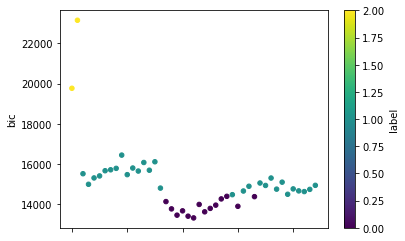

In [110]:
_, sparkS = next(sparksDF.loc[(sparksDF.loc[:, 'tIni']<=2003)&(sparksDF.loc[:, 'tFin']>=2003), :].iterrows())
bics_list = []
for idx in range(sparkS['tIni'], sparkS['tFin']):
    im = cv2.imread(get_image_path(idx))
    im_ = im.copy()

    sparkLocations = get_spark_location(sparksDF, idx)
    gmmCounts = []
    # only first one
    i, sparkLocation = next(sparkLocations.iterrows())

    mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)
    nComp, bic = get_optimal_ncomponents_and_bic_gmm(im[mask].reshape(-1,1))
    
    bics_list.append(round(bic,2))

bics = np.array(bics_list).reshape(-1, 1)
# k = KMeans(n_clusters=2).fit(bics)
nComp, bic = get_optimal_ncomponents_and_bic_gmm(bics)
gmm = mixture.GaussianMixture(n_components=nComp).fit(bics)
lab = gmm.predict(bics)
df = pd.DataFrame([bics_list, lab], index=['bic', 'label']).T.reset_index()
df.plot.scatter(x='index', y='bic', c='label', cmap='viridis')
plt.show()

### savefig spark frames GMM

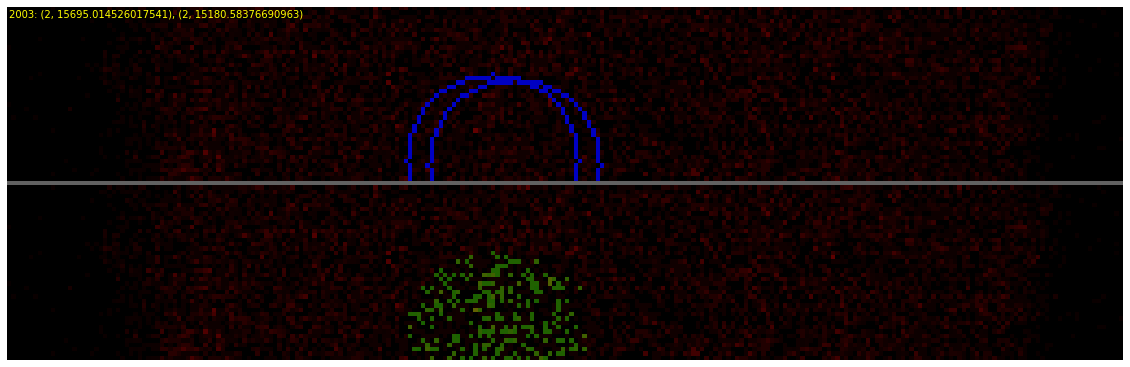

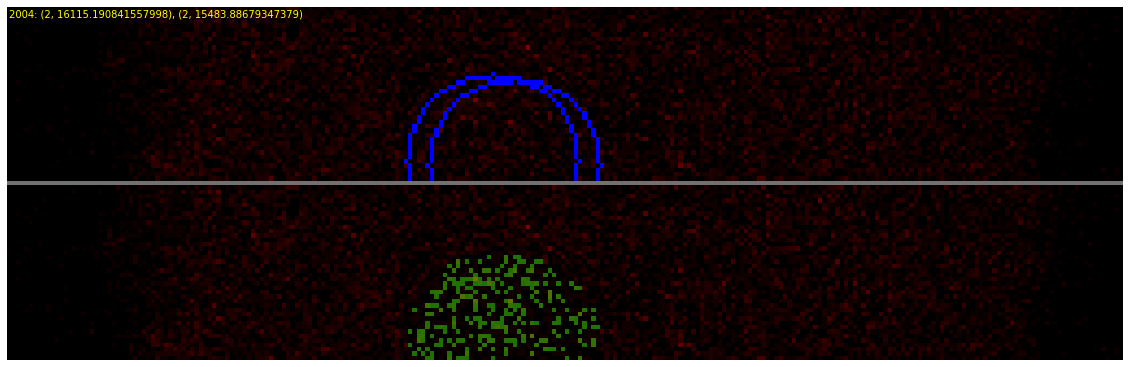

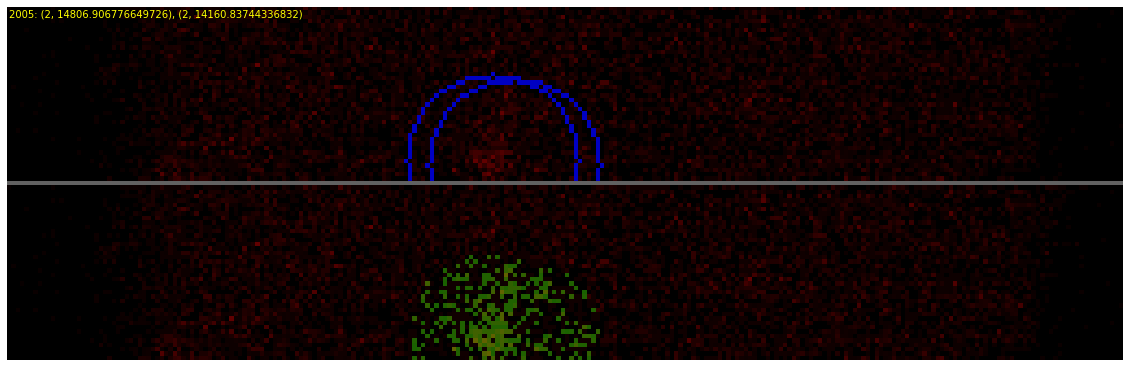

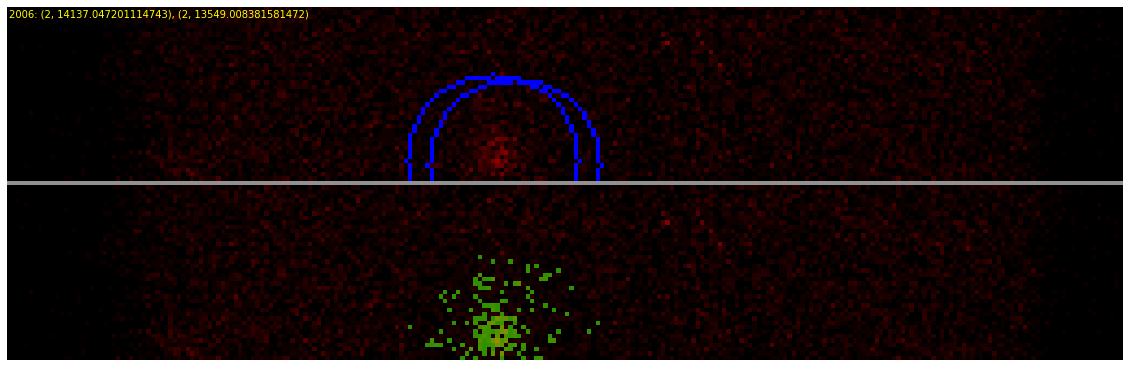

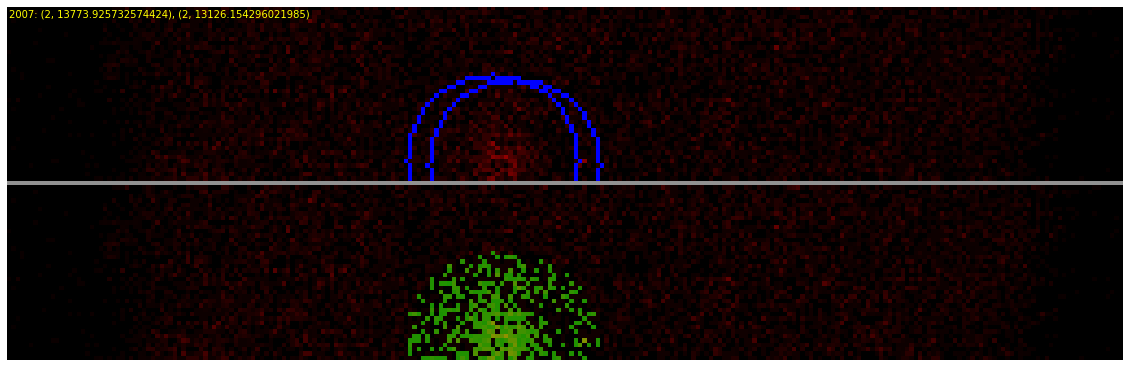

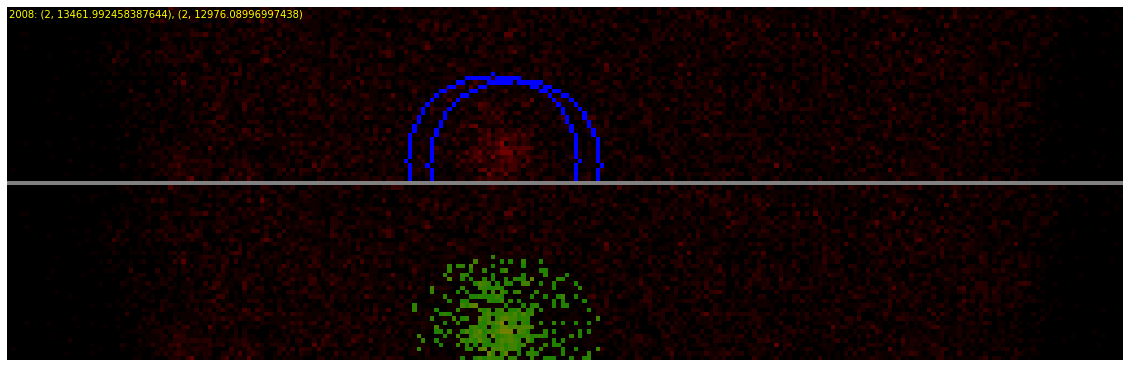

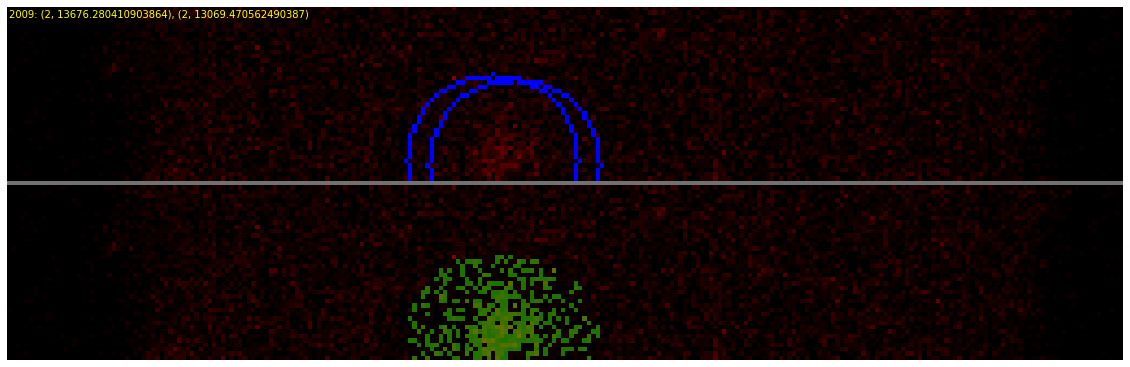

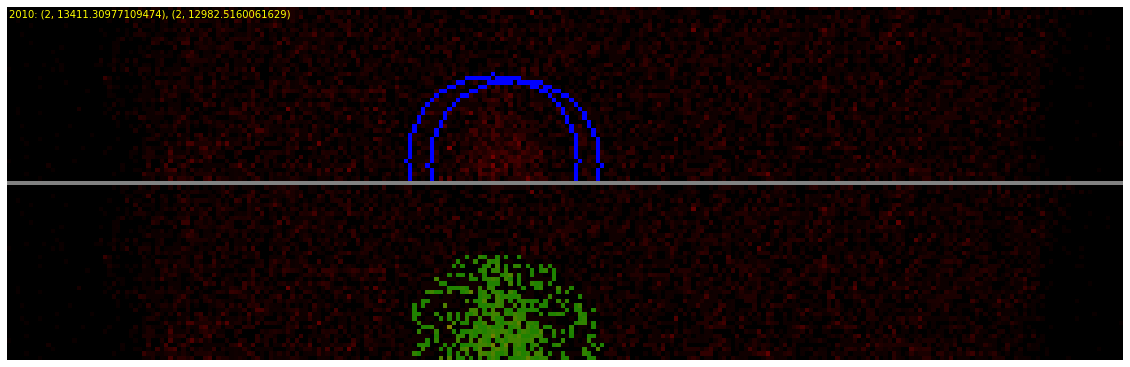

In [51]:
idx = 2008
for idx in range(2003, 2010+1):
    im = cv2.imread(get_image_path(idx))
    im_top = im.copy()
    im_ = im.copy()
    
    sparkLocations = get_spark_location(sparksDF, idx)
    gmmCounts = []
    for i, sparkLocation in sparkLocations.iterrows():
        color = int(im.max()*2)
        cv2.circle(im_top, (sparkLocation['x'], sparkLocation['y']), 20, color, thickness=1, lineType=8, shift=0)
        
        mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

        #calcula el BIC per trobar el número de gaussianes òptim
        NMAX = 10
        bic = []

        for kG in np.arange(1,NMAX+1):
            gmm = mixture.GaussianMixture(n_components=kG).fit(im[mask].reshape(-1,1))
            bic.append(gmm.bic(im[mask].reshape(-1,1))) #cada cop va afegint el bic amb kG+1, així ho tens tot en un vector i pots calcualr el mínim

        idx_winner = np.argmin(np.abs(bic))
        gmmCounts.append((idx_winner+1,np.min(np.abs(bic))))
        gmm = mixture.GaussianMixture(n_components=(idx_winner+1)).fit(im[mask].reshape(-1,3))
        lab = gmm.predict(im[mask].reshape(-1,3))
        
        maxRValue = im[mask,2].max()
        maxValue = np.array([0, 0, maxRValue]).reshape(-1,3)
        maxValueIdx = im[mask, 2].argmax()
        isSparkCond = np.full(im_[mask].shape, False)
        isSparkCond[lab == lab[maxValueIdx], 1] = True
        im_[mask] = np.where(isSparkCond, maxRValue, im_[mask])

    conc_im = np.concatenate((im_top, np.full((1,im.shape[1], 3), maxRValue), im_))
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(conc_im, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    # plt.title(f"{idx}")
    plt.text(0, 0, f"{idx}: "+', '.join(str(c) for c in gmmCounts), c='yellow', verticalalignment='top')
    # plt.savefig(f"_out/spark{idx}", bbox_inches = 'tight', pad_inches = 0)
    plt.show()

## Normaization 
$F_0 = mean(F \in cell | \forall frames)$  
$F_n = \frac{F-F_0}{F_0}$

### Build cell mask

In [22]:
BACKGROUND_MAX_VALUE = 0

cellMask = np.zeros(get_image_array(0).shape)
for i in range(len(imageList)):
    im1 = get_image_array(i)
    auxMask = im1 > BACKGROUND_MAX_VALUE
    cellMask += auxMask

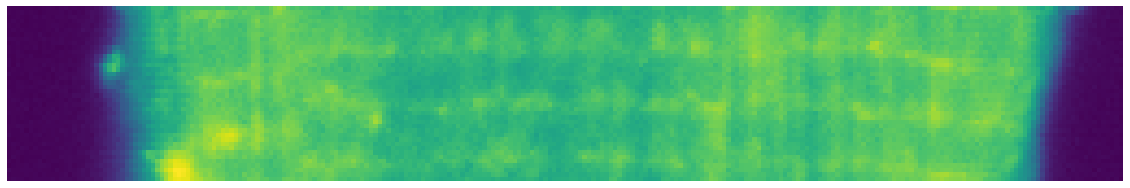

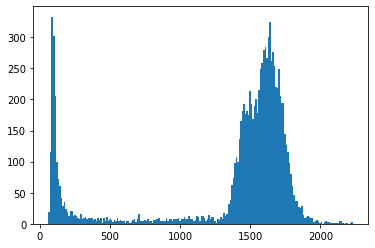

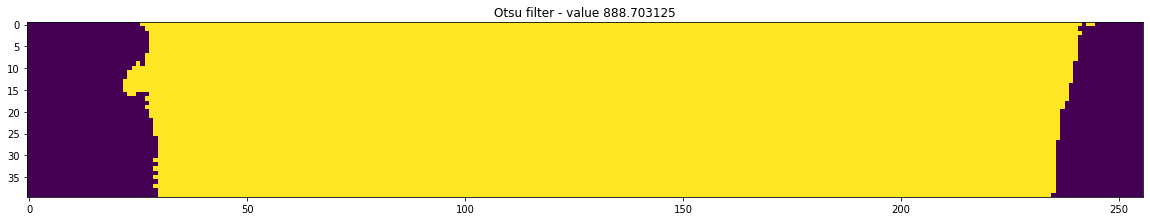

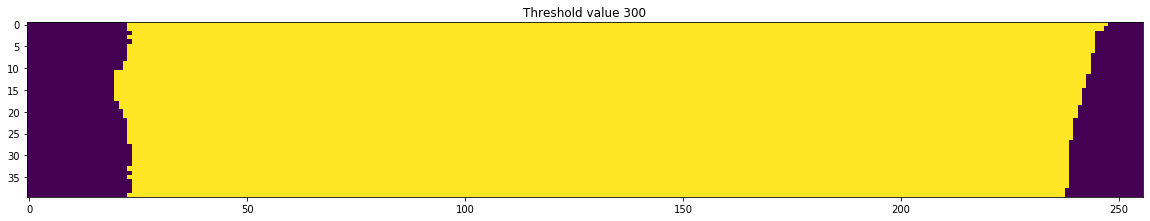

In [23]:
# cellMask = im1 > BACKGROUND_MAX_VALUE
plt.figure(figsize=(20, 10))
plt.imshow(cellMask)
plt.axis('off')
# plt.savefig(f"_out/cellmask", bbox_inches = 'tight', pad_inches = 0)
plt.show()


plt.hist(cellMask.flatten(), bins=200)
plt.show()

plt.figure(figsize=(20, 10))
thr = threshold_otsu(cellMask)
plt.imshow(cellMask > thr)
plt.title(f'Otsu filter - value {thr}')
plt.show()

plt.figure(figsize=(20, 10))
thr = 300
plt.imshow(cellMask > thr)
plt.title(f'Threshold value {thr}')
plt.show()

In [24]:
cellMask = cellMask > threshold_otsu(cellMask)

### Value counts

In [25]:
res = pd.Series(dtype='int')
for i in range(len(imageList)):
    im1 = get_image_array(i)
    s1 = pd.Series(im1[cellMask].flatten())
    g1 = s1.groupby(s1).size()
    
    res = pd.concat([res, g1], axis=1).fillna(0, downcast='infer').sum(axis=1)

# res

### F0

In [26]:
F0 = (res*res.index).sum()/res.sum()
F0

15.179870023905599

In [27]:
F0, maxValue, cellMask = get_f0_and_cellmask()

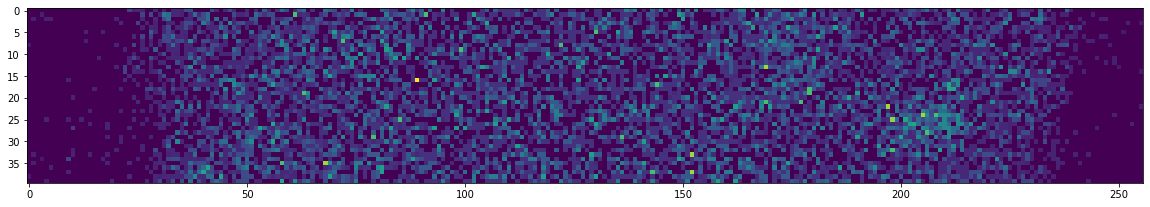

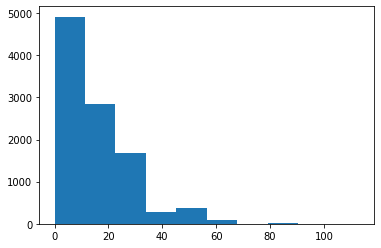

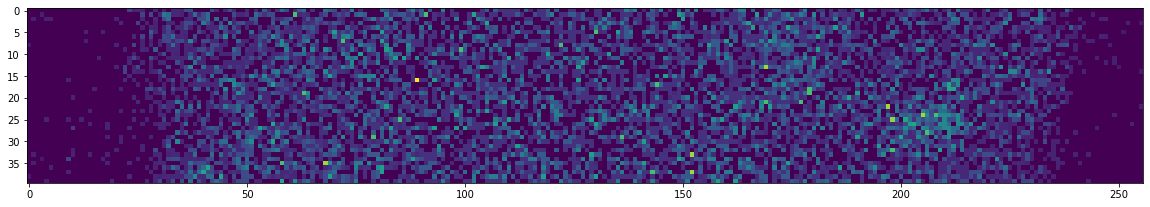

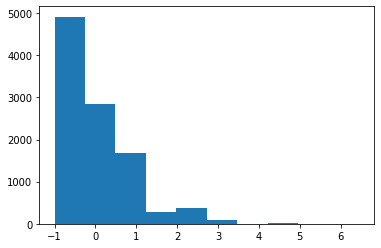

In [28]:
idx = 130
im = get_image_array(idx)

plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

plt.hist(im.flatten())
plt.show()

im = get_normalized_frame(im, F0)

plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

plt.hist(im.flatten())
plt.show()